<a href="https://colab.research.google.com/github/toraaglobal/CaseStudies/blob/master/regression_coaches_salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can you Predict Your Football Head Coach Salary?
***
**Name**: Tajudeen Abdulazeez
**Email**: toabdula@syr.edu

***




## [Analysis Report](https://www.dropbox.com/s/txna80z35tfsz7b/lab_1_Tajudeen_Abdulazeez.docx?dl=0)





## Problem Defination and Data Gathering

### Proble Defination
* How can you reccommend the best salaries (Total compensation minus Bonus) for a head food ball coach ?
* Create a predictive model to predict a coach salary using avaialable data
* Determined the factors that influence the coaches salaries

### Model Evaluation Metrics
* The root mean square error between the actual and the predicted is used as an evaluation  the performance of the predictive model 

$$ RMSE = \sqrt{\frac{{{sum_{i=1}^{n}} {(Predicted -Actual)^2}}} n} $$




In [0]:
#Packages
import os
print(os.listdir('./'))

from google.colab import drive
drive.mount('/content/drive')

os.chdir('./drive/My Drive/Colab Notebooks/code')



import re
import urllib
from bs4 import BeautifulSoup
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt


import requests
import pprint

%matplotlib inline


['.config', 'sample_data']
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def generate_corr_plot(df):
    '''  correlation matrix of dataframe'''
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    #f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    
    
    
    
def obj2num_col2(df, col):
    '''convert and object column in a dataframe to numeric. and remove the special character $ from the value'''
    #df[col] = df[col].astype(str)
    df[col] = df[col].str.replace(',','')
    df[col] = df[col].str.replace('--','')
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('\[..\]', '')
    df[col] = df[col].str.replace('\(.+\)', '')
    df[col] = df[col].convert_objects(convert_numeric=True) 
    return df
  
  

def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        #return "The strings are {} edits away".format(distance[row][col])
        return distance[row][col]
      
      

## Data Source 


** Data Source 1 **

Sources from US Today

'https://sports.usatoday.com/ncaa/salaries/'


In [0]:
url2 = 'https://sports.usatoday.com/ncaa/salaries/'


#load the coaches datasets
coaches_html = pd.read_html(url2, index_col=1, attrs={'class': 'datatable datatable-salaries fixed-column'}, header=0)[0]

print('Data Source URL: {}'.format(url2))
print(coaches_html.shape)
coaches_html.head()

Data Source URL: https://sports.usatoday.com/ncaa/salaries/
(131, 9)


,Rk,Conf,Coach,School Pay,Total Pay,Max Bonus,Bonuses Paid (2017-18),Asst Pay Total,School Buyout As Of 4/1/19
School,,,,,,,,,
Alabama,1,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000","$6,123,723","$33,600,000"
Ohio State,2,Big Ten,Urban Meyer,"$7,600,000","$7,600,000","$775,000","$350,000","$7,383,938","$38,058,402"
Michigan,3,Big Ten,Jim Harbaugh,"$7,504,000","$7,504,000","$1,325,000","$150,000","$5,875,000","$17,111,110"
Texas A&M,4,SEC,Jimbo Fisher,"$7,500,000","$7,500,000","$1,350,000",--,"$6,789,640","$68,125,000"
Auburn,5,SEC,Gus Malzahn,"$6,700,000","$6,705,656","$1,400,000","$375,000","$6,555,600","$32,143,750"


Get the dataframe information

In [0]:
coaches_html.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, Alabama to School
Data columns (total 9 columns):
Rk                            131 non-null object
Conf                          131 non-null object
Coach                         131 non-null object
School Pay                    131 non-null object
Total Pay                     131 non-null object
Max Bonus                     131 non-null object
Bonuses Paid (2017-18)        131 non-null object
Asst Pay Total                131 non-null object
School Buyout As Of 4/1/19    131 non-null object
dtypes: object(9)
memory usage: 10.2+ KB


In [0]:
print(coaches_html.shape)


(131, 9)


** Data Source 2 **:
** Stadium Size**

``'http://en.wikipedia.org/wiki/List_of_American_football_stadiums_by_capacity'``

In [0]:
url3 = 'http://en.wikipedia.org/wiki/List_of_American_football_stadiums_by_capacity'

stadiums = pd.read_html(url3,index_col=1, attrs={'class':'wikitable'}, header=0)[0]

print(stadiums.shape)
print("Data Source: {}".format(url3))
stadiums.head()

(150, 7)
Data Source: http://en.wikipedia.org/wiki/List_of_American_football_stadiums_by_capacity


,Image,Capacity,City,State/Province,Home teams,Refs,Unnamed: 7
Stadium,,,,,,,
Michigan Stadium,NaN,107601,Ann Arbor,Michigan,Michigan Wolverines,[1],NaN
Beaver Stadium,NaN,106572,University Park,Pennsylvania,Penn State Nittany Lions,[2],NaN
Kyle Field,NaN,102733,College Station,Texas,Texas A&M Aggies,NaN,NaN
Neyland Stadium,NaN,102455,Knoxville,Tennessee,Tennessee Volunteers,[3],NaN
Tiger Stadium,NaN,102321,Baton Rouge,Louisiana,LSU Tigers,[4],NaN


Get Dataframe information

In [0]:
stadiums.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, Michigan Stadium to Joe Aillet Stadium
Data columns (total 7 columns):
Image             0 non-null float64
Capacity          150 non-null object
City              150 non-null object
State/Province    150 non-null object
Home teams        150 non-null object
Refs              31 non-null object
Unnamed: 7        2 non-null object
dtypes: float64(1), object(6)
memory usage: 9.4+ KB


** Data Source 3 ** : **GSR**

https://web3.ncaa.org/aprsearch/gsrsearch

In [0]:
gcr  = pd.read_csv("../data/gcr.csv")

gcr.head()

,Cohort Year,School,Conference,Sport,State,GSR,FGR
0,2011,Abilene Christian University,Southland Conference,Football,TX,61,41.0
1,2011,University of Akron,Mid-American Conference,Football,OH,72,61.0
2,2011,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,62,47.0
3,2011,Alabama State University,Southwestern Athletic Conf.,Football,AL,58,42.0
4,2011,University of Alabama,Southeastern Conference,Football,AL,84,63.0


**Data Source 4**: Coach W/L


 'https://www.pro-football-reference.com/coaches/'

In [0]:
url4 = 'https://www.pro-football-reference.com/coaches/'
wl_record = pd.read_html(url4, index_col=1, attrs={'class' : "sortable stats_table"}, header=0)[0]
wl_record.head()

,Rk,Yrs,Yr-Yr,G,W,L,T,W-L%,G > .500,Yr plyf,G plyf,W plyf,L plyf,W-L%.1,AvRk,BstRk,Chmp,SBwl,Conf
Coach,,,,,,,,,,,,,,,,,,,
Don Shula+,1,33,1963-1995,490,328,156,6,0.677,172,19.0,36.0,19.0,17.0,0.528,1.8,1,2.0,2.0,6.0
George Halas+,2,40,1920-1967,497,318,148,31,0.682,170,8.0,9.0,6.0,3.0,0.667,2.7,1,6.0,0.0,0.0
Bill Belichick,3,24,1991-2018,384,261,123,0,0.680,138,17.0,42.0,31.0,11.0,0.738,1.7,1,6.0,6.0,9.0
Tom Landry+,4,29,1960-1988,418,250,162,6,0.607,88,18.0,36.0,20.0,16.0,0.556,2.4,1,2.0,2.0,5.0
Curly Lambeau+,5,33,1921-1953,380,226,132,22,0.631,94,5.0,5.0,3.0,2.0,0.600,3.2,1,6.0,0.0,0.0


In [0]:
wl_record.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, Don Shula+ to Lenny Sachs
Data columns (total 19 columns):
Rk          494 non-null int64
Yrs         494 non-null int64
Yr-Yr       494 non-null object
G           494 non-null int64
W           494 non-null int64
L           494 non-null int64
T           494 non-null int64
W-L%        494 non-null float64
G > .500    494 non-null int64
Yr plyf     486 non-null float64
G plyf      486 non-null float64
W plyf      486 non-null float64
L plyf      486 non-null float64
W-L%.1      169 non-null float64
AvRk        494 non-null float64
BstRk       494 non-null int64
Chmp        443 non-null float64
SBwl        442 non-null float64
Conf        445 non-null float64
dtypes: float64(10), int64(8), object(1)
memory usage: 77.2+ KB


## Data Prep

In [0]:
## coaches

print('coaches_html.columns')

renamecol = {'Rk': 'Rank', 'Conf': 'Conference','Coach':'Coach', 'School Pay': 'SchoolPay','Total Pay':'TotalPay', 'Max Bonus':'MaxBonus', 
             'Bonuses Paid (2017-18)': 'BonusPaid', 'Asst Pay Total':'AssistancePay', 'School Buyout As Of 4/1/19': 'BuyOut'}


coaches_html.rename(index=str, columns=renamecol, inplace=True)
print('='*50)
print(coaches_html.head())


print("Reseting Index")

coaches_html.reset_index(inplace=True)
print(coaches_html.head())

print('='*50)

print(coaches_html.tail(20))

#drop the last row
coaches_html.drop(coaches_html.tail(1).index,inplace=True) 

print(coaches_html.tail())


#* Convert columns to the right data type format

coltoconvert = ['SchoolPay', 'TotalPay', 'MaxBonus','BonusPaid', 'AssistancePay', 'BuyOut']
print('='*50)
print('Data Summary')

print(coaches_html.describe(include=['O']))


for col in coltoconvert:
    obj2num_col2(coaches_html, col)
    
print(coaches_html.describe(include=['O']))

print(coaches_html.head(10))

coaches_html.columns
           Rank Conference         Coach   SchoolPay    TotalPay    MaxBonus  \
School                                                                         
Alabama       1        SEC    Nick Saban  $8,307,000  $8,307,000  $1,100,000   
Ohio State    2    Big Ten   Urban Meyer  $7,600,000  $7,600,000    $775,000   
Michigan      3    Big Ten  Jim Harbaugh  $7,504,000  $7,504,000  $1,325,000   
Texas A&M     4        SEC  Jimbo Fisher  $7,500,000  $7,500,000  $1,350,000   
Auburn        5        SEC   Gus Malzahn  $6,700,000  $6,705,656  $1,400,000   

           BonusPaid AssistancePay       BuyOut  
School                                           
Alabama     $500,000    $6,123,723  $33,600,000  
Ohio State  $350,000    $7,383,938  $38,058,402  
Michigan    $150,000    $5,875,000  $17,111,110  
Texas A&M         --    $6,789,640  $68,125,000  
Auburn      $375,000    $6,555,600  $32,143,750  
Reseting Index
       School Rank Conference         Coach   SchoolP

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [0]:
coaches_html.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 10 columns):
School           130 non-null object
Rank             130 non-null object
Conference       130 non-null object
Coach            130 non-null object
SchoolPay        123 non-null float64
TotalPay         123 non-null float64
MaxBonus         106 non-null float64
BonusPaid        88 non-null float64
AssistancePay    130 non-null int64
BuyOut           107 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 11.2+ KB


In [0]:
coaches_html['Rank'] = coaches_html['Rank'].convert_objects(convert_numeric=True)

coaches_html.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 10 columns):
School           130 non-null object
Rank             130 non-null int64
Conference       130 non-null object
Coach            130 non-null object
SchoolPay        123 non-null float64
TotalPay         123 non-null float64
MaxBonus         106 non-null float64
BonusPaid        88 non-null float64
AssistancePay    130 non-null int64
BuyOut           107 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 11.2+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [0]:
## Stadium
print(stadiums.info())

print(stadiums.head())

stadiums.reset_index(inplace=True)
print(stadiums.head())

#summary
print(stadiums.describe(include=['O']))


<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, Michigan Stadium to Joe Aillet Stadium
Data columns (total 7 columns):
Image             0 non-null float64
Capacity          150 non-null object
City              150 non-null object
State/Province    150 non-null object
Home teams        150 non-null object
Refs              31 non-null object
Unnamed: 7        2 non-null object
dtypes: float64(1), object(6)
memory usage: 9.4+ KB
None
                  Image Capacity             City State/Province  \
Stadium                                                            
Michigan Stadium    NaN   107601        Ann Arbor       Michigan   
Beaver Stadium      NaN   106572  University Park   Pennsylvania   
Kyle Field          NaN   102733  College Station          Texas   
Neyland Stadium     NaN   102455        Knoxville      Tennessee   
Tiger Stadium       NaN   102321      Baton Rouge      Louisiana   

                                Home teams Refs Unnamed: 7  
Stadium       

In [0]:
#checking column matching between Home Team and School
matches = {}
hometeam = stadiums['Home teams'].values
print(len(hometeam))

schoolname = coaches_html['School'].values
print(len(schoolname))

for elm in hometeam:
    for el in schoolname:
        if levenshtein_ratio_and_distance(elm, el, ratio_calc=True) > 0.7:
            matches[elm] = el

            
print(matches)

150
130
{'Texas A&M Aggies': 'Texas A&M', 'Florida Gators': 'Florida State', 'Oklahoma Sooners': 'Oklahoma State', 'South Carolina Gamecocks': 'South Carolina', 'Florida State Seminoles': 'Florida State', 'Michigan State Spartans': 'Michigan State', 'Washington Huskies': 'Washington State', 'Virginia Tech Hokies': 'Virginia Tech', 'North Carolina Tar Heels': 'North Carolina', 'Mississippi State Bulldogs': 'Mississippi State', 'Oklahoma State Cowboys': 'Oklahoma State', 'Kansas State Wildcats': 'Kansas State', 'East Carolina Pirates': 'East Carolina', 'Northwestern Wildcats': 'Northwestern', 'Oregon State Beavers': 'Oregon State', 'Utah Utes': 'Utah State', 'Boston College Eagles': 'Boston College', 'Fresno State Bulldogs': 'Fresno State', 'Colorado State Rams.': 'Colorado State', 'Connecticut Huskies': 'Connecticut', "Louisiana-Lafayette Ragin' Cajuns": 'Louisiana-Lafayette', 'Washington State Cougars': 'Washington State', 'Middle Tennessee Blue Raiders': 'Middle Tennessee', 'Northern 

In [0]:
selcol = ['Stadium','Capacity','City','State/Province','Home teams']

stadDF = stadiums[selcol]

print(stadDF.head())
print(stadDF.shape)


#rename columns

rencol = {'Stadium' : 'Stadium','Capacity': 'Capacity','City':'City','State/Province':'State','Home teams':'HomeTeams'}

stadDF.rename(index=str, columns=rencol, inplace=True)

print(stadDF.head())

            Stadium Capacity             City State/Province  \
0  Michigan Stadium   107601        Ann Arbor       Michigan   
1    Beaver Stadium   106572  University Park   Pennsylvania   
2        Kyle Field   102733  College Station          Texas   
3   Neyland Stadium   102455        Knoxville      Tennessee   
4     Tiger Stadium   102321      Baton Rouge      Louisiana   

                 Home teams  
0       Michigan Wolverines  
1  Penn State Nittany Lions  
2          Texas A&M Aggies  
3      Tennessee Volunteers  
4                LSU Tigers  
(150, 5)
            Stadium Capacity             City         State  \
0  Michigan Stadium   107601        Ann Arbor      Michigan   
1    Beaver Stadium   106572  University Park  Pennsylvania   
2        Kyle Field   102733  College Station         Texas   
3   Neyland Stadium   102455        Knoxville     Tennessee   
4     Tiger Stadium   102321      Baton Rouge     Louisiana   

                  HomeTeams  
0       Michigan 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
# GSR

print(gcr.head())
print(gcr.shape)

   Cohort Year                        School                   Conference  \
0         2011  Abilene Christian University         Southland Conference   
1         2011           University of Akron      Mid-American Conference   
2         2011        Alabama A&M University  Southwestern Athletic Conf.   
3         2011      Alabama State University  Southwestern Athletic Conf.   
4         2011         University of Alabama      Southeastern Conference   

      Sport State  GSR   FGR  
0  Football    TX   61  41.0  
1  Football    OH   72  61.0  
2  Football    AL   62  47.0  
3  Football    AL   58  42.0  
4  Football    AL   84  63.0  
(249, 7)


In [0]:
## Coach win and loss record
#'https://www.pro-football-reference.com/coaches/'
print(wl_record.head())

                Rk  Yrs      Yr-Yr    G    W    L   T   W-L%  G > .500  \
Coach                                                                    
Don Shula+       1   33  1963-1995  490  328  156   6  0.677       172   
George Halas+    2   40  1920-1967  497  318  148  31  0.682       170   
Bill Belichick   3   24  1991-2018  384  261  123   0  0.680       138   
Tom Landry+      4   29  1960-1988  418  250  162   6  0.607        88   
Curly Lambeau+   5   33  1921-1953  380  226  132  22  0.631        94   

                Yr plyf  G plyf  W plyf  L plyf  W-L%.1  AvRk  BstRk  Chmp  \
Coach                                                                        
Don Shula+         19.0    36.0    19.0    17.0   0.528   1.8      1   2.0   
George Halas+       8.0     9.0     6.0     3.0   0.667   2.7      1   6.0   
Bill Belichick     17.0    42.0    31.0    11.0   0.738   1.7      1   6.0   
Tom Landry+        18.0    36.0    20.0    16.0   0.556   2.4      1   2.0   
Curly Lambeau

In [0]:
wl_record.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, Don Shula+ to Lenny Sachs
Data columns (total 19 columns):
Rk          494 non-null int64
Yrs         494 non-null int64
Yr-Yr       494 non-null object
G           494 non-null int64
W           494 non-null int64
L           494 non-null int64
T           494 non-null int64
W-L%        494 non-null float64
G > .500    494 non-null int64
Yr plyf     486 non-null float64
G plyf      486 non-null float64
W plyf      486 non-null float64
L plyf      486 non-null float64
W-L%.1      169 non-null float64
AvRk        494 non-null float64
BstRk       494 non-null int64
Chmp        443 non-null float64
SBwl        442 non-null float64
Conf        445 non-null float64
dtypes: float64(10), int64(8), object(1)
memory usage: 77.2+ KB


In [0]:
print(wl_record.columns)

Index(['Rk', 'Yrs', 'Yr-Yr', 'G', 'W', 'L', 'T', 'W-L%', 'G > .500', 'Yr plyf',
       'G plyf', 'W plyf', 'L plyf', 'W-L%.1', 'AvRk', 'BstRk', 'Chmp', 'SBwl',
       'Conf'],
      dtype='object')


In [0]:
col2sel = ['Rk','Yrs','G', 'W', 'L', 'T','W-L%','Conf']

wl_record = wl_record[col2sel]

wl_record.head()

,Rk,Yrs,G,W,L,T,W-L%,Conf
Coach,,,,,,,,
Don Shula+,1,33,490,328,156,6,0.677,6.0
George Halas+,2,40,497,318,148,31,0.682,0.0
Bill Belichick,3,24,384,261,123,0,0.680,9.0
Tom Landry+,4,29,418,250,162,6,0.607,5.0
Curly Lambeau+,5,33,380,226,132,22,0.631,0.0


In [0]:
## reset index and remove the special character in name

wl_record.reset_index(inplace=True)
print(wl_record.head())


wl_record['Coach'] = wl_record['Coach'].str.replace('\+', '')
print('='*50)

print(wl_record.head())



            Coach  Rk  Yrs    G    W    L   T   W-L%  Conf
0      Don Shula+   1   33  490  328  156   6  0.677   6.0
1   George Halas+   2   40  497  318  148  31  0.682   0.0
2  Bill Belichick   3   24  384  261  123   0  0.680   9.0
3     Tom Landry+   4   29  418  250  162   6  0.607   5.0
4  Curly Lambeau+   5   33  380  226  132  22  0.631   0.0
            Coach  Rk  Yrs    G    W    L   T   W-L%  Conf
0       Don Shula   1   33  490  328  156   6  0.677   6.0
1    George Halas   2   40  497  318  148  31  0.682   0.0
2  Bill Belichick   3   24  384  261  123   0  0.680   9.0
3      Tom Landry   4   29  418  250  162   6  0.607   5.0
4   Curly Lambeau   5   33  380  226  132  22  0.631   0.0


####  Merge Dataframe

In [0]:
coaches_html.head()

,School,Rank,Conference,Coach,SchoolPay,TotalPay,MaxBonus,BonusPaid,AssistancePay,BuyOut
0,Alabama,1,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,6123723,33600000.0
1,Ohio State,2,Big Ten,Urban Meyer,7600000.0,7600000.0,775000.0,350000.0,7383938,38058402.0
2,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,7504000.0,1325000.0,150000.0,5875000,17111110.0
3,Texas A&M,4,SEC,Jimbo Fisher,7500000.0,7500000.0,1350000.0,NaN,6789640,68125000.0
4,Auburn,5,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,6555600,32143750.0


In [0]:
stadDF.head()

,Stadium,Capacity,City,State,HomeTeams
0,Michigan Stadium,107601,Ann Arbor,Michigan,Michigan Wolverines
1,Beaver Stadium,106572,University Park,Pennsylvania,Penn State Nittany Lions
2,Kyle Field,102733,College Station,Texas,Texas A&M Aggies
3,Neyland Stadium,102455,Knoxville,Tennessee,Tennessee Volunteers
4,Tiger Stadium,102321,Baton Rouge,Louisiana,LSU Tigers


In [0]:
gcr.head()

,Cohort Year,School,Conference,Sport,State,GSR,FGR
0,2011,Abilene Christian University,Southland Conference,Football,TX,61,41.0
1,2011,University of Akron,Mid-American Conference,Football,OH,72,61.0
2,2011,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,62,47.0
3,2011,Alabama State University,Southwestern Athletic Conf.,Football,AL,58,42.0
4,2011,University of Alabama,Southeastern Conference,Football,AL,84,63.0


In [0]:
wl_record.head()

,Coach,Rk,Yrs,G,W,L,T,W-L%,Conf
0,Don Shula,1,33,490,328,156,6,0.677,6.0
1,George Halas,2,40,497,318,148,31,0.682,0.0
2,Bill Belichick,3,24,384,261,123,0,0.680,9.0
3,Tom Landry,4,29,418,250,162,6,0.607,5.0
4,Curly Lambeau,5,33,380,226,132,22,0.631,0.0


In [0]:
##coach and wl record

coach_wl_record = coaches_html.merge(wl_record, left_on ='Coach', right_on='Coach' ,how='left')

coach_wl_record.head(30)

,School,Rank,Conference,Coach,SchoolPay,TotalPay,MaxBonus,BonusPaid,AssistancePay,BuyOut,Rk,Yrs,G,W,L,T,W-L%,Conf
0,Alabama,1,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,6123723,33600000.0,219.0,2.0,32.0,15.0,17.0,0.0,0.469,0.0
1,Ohio State,2,Big Ten,Urban Meyer,7600000.0,7600000.0,775000.0,350000.0,7383938,38058402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,7504000.0,1325000.0,150000.0,5875000,17111110.0,110.0,4.0,64.0,44.0,19.0,1.0,0.695,1.0
3,Texas A&M,4,SEC,Jimbo Fisher,7500000.0,7500000.0,1350000.0,NaN,6789640,68125000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Auburn,5,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,6555600,32143750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Georgia,6,SEC,Kirby Smart,6603600.0,6603600.0,1150000.0,1350000.0,6420000,27917500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Clemson,7,ACC,Dabo Swinney,6205000.0,6543350.0,1125000.0,500000.0,6825000,35000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Florida,8,SEC,Dan Mullen,6070000.0,6070000.0,925000.0,NaN,4855000,12000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Texas,9,Big 12,Tom Herman,5500000.0,5500000.0,725000.0,75000.0,5955000,15416667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Nebraska,10,Big Ten,Scott Frost,5000000.0,5000000.0,950000.0,NaN,4500000,25416667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
coach_wl_record.shape

(130, 18)

In [0]:

for elm in coaches_html['School'].values:
    for el in stadDF['HomeTeams'].values:
        if elm in el:
            print(elm,'====================', el)

Alabama ==================== Alabama Crimson Tide
Alabama ==================== UAB Blazers (Main tenant), the Magic City Classic game, and the BBVA Compass Bowl game; former part-time home for Alabama (full-time for 1987) and Auburn
Alabama ==================== South Alabama Jaguars, the GoDaddy.com Bowl game, and the Senior Bowl game
Ohio State ==================== Ohio State Buckeyes
Michigan ==================== Michigan Wolverines
Michigan ==================== Michigan State Spartans
Michigan ==================== Eastern Michigan Eagles
Michigan ==================== Central Michigan Chippewas
Michigan ==================== Western Michigan Broncos
Texas A&M ==================== Texas A&M Aggies
Auburn ==================== Auburn Tigers
Auburn ==================== UAB Blazers (Main tenant), the Magic City Classic game, and the BBVA Compass Bowl game; former part-time home for Alabama (full-time for 1987) and Auburn
Georgia ==================== Georgia Bulldogs
Georgia ===============

In [0]:
mydict = {}
for elm in coaches_html['School'].values:
    for el in stadDF['HomeTeams'].values:
        if elm in el:
            mydict[el] = elm
            
            
            
stadDF['school'] = stadDF['HomeTeams']

print(stadDF.head())


stadDF.replace({'school':mydict}, inplace=True)

print(stadDF.head())


temp = stadDF.copy()

temp = obj2num_col2(temp, 'Capacity')

print(temp.tail(25))



            Stadium Capacity             City         State  \
0  Michigan Stadium   107601        Ann Arbor      Michigan   
1    Beaver Stadium   106572  University Park  Pennsylvania   
2        Kyle Field   102733  College Station         Texas   
3   Neyland Stadium   102455        Knoxville     Tennessee   
4     Tiger Stadium   102321      Baton Rouge     Louisiana   

                  HomeTeams                    school  
0       Michigan Wolverines       Michigan Wolverines  
1  Penn State Nittany Lions  Penn State Nittany Lions  
2          Texas A&M Aggies          Texas A&M Aggies  
3      Tennessee Volunteers      Tennessee Volunteers  
4                LSU Tigers                LSU Tigers  
            Stadium Capacity             City         State  \
0  Michigan Stadium   107601        Ann Arbor      Michigan   
1    Beaver Stadium   106572  University Park  Pennsylvania   
2        Kyle Field   102733  College Station         Texas   
3   Neyland Stadium   102455     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and

In [0]:
coach_plus2 = coach_wl_record.merge(temp, left_on ='School', right_on='school')

coach_plus2.head()

,School,Rank,Conference,Coach,SchoolPay,TotalPay,MaxBonus,BonusPaid,AssistancePay,BuyOut,...,L,T,W-L%,Conf,Stadium,Capacity,City,State,HomeTeams,school
0,Alabama,1,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,6123723,33600000.0,...,17.0,0.0,0.469,0.0,Bryant–Denny Stadium,101821,Tuscaloosa,Alabama,Alabama Crimson Tide,Alabama
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,7504000.0,1325000.0,150000.0,5875000,17111110.0,...,19.0,1.0,0.695,1.0,Michigan Stadium,107601,Ann Arbor,Michigan,Michigan Wolverines,Michigan
2,Auburn,5,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,6555600,32143750.0,...,NaN,NaN,NaN,NaN,Jordan-Hare Stadium,87451,Auburn,Alabama,Auburn Tigers,Auburn
3,Auburn,5,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,6555600,32143750.0,...,NaN,NaN,NaN,NaN,Legion Field,71594,Birmingham,Alabama,"UAB Blazers (Main tenant), the Magic City Clas...",Auburn
4,Georgia,6,SEC,Kirby Smart,6603600.0,6603600.0,1150000.0,1350000.0,6420000,27917500.0,...,NaN,NaN,NaN,NaN,Sanford Stadium,92746,Athens,Georgia,Georgia Bulldogs,Georgia


In [0]:
coach_plus2.shape

(113, 24)

In [0]:
coach_plus2.to_csv('../data/coach_plus2.csv')

In [0]:
schcoach = {}

for sch in coach_plus2['School'].values:
    for schg in gcr['School'].values:
        if sch in schg:
            schcoach[sch] = schg
            
schcoach

{'Air Force': 'U.S. Air Force Academy',
 'Akron': 'University of Akron',
 'Alabama': 'University of South Alabama',
 'Arizona': 'Northern Arizona University',
 'Arizona State': 'Arizona State University',
 'Arkansas': 'University of Arkansas, Pine Bluff',
 'Arkansas State': 'Arkansas State University',
 'Auburn': 'Auburn University',
 'Baylor': 'Baylor University',
 'Boise State': 'Boise State University',
 'Boston College': 'Boston College',
 'Buffalo': 'University at Buffalo, the State University of New York',
 'California': 'University of Southern California',
 'Central Michigan': 'Central Michigan University',
 'Cincinnati': 'University of Cincinnati',
 'Clemson': 'Clemson University',
 'Colorado State': 'Colorado State University',
 'Connecticut': 'University of Connecticut',
 'Duke': 'Duke University',
 'East Carolina': 'East Carolina University',
 'Eastern Michigan': 'Eastern Michigan University',
 'Florida': 'University of South Florida',
 'Florida Atlantic': 'Florida Atlantic 

In [0]:
def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate Coaches'''
    clean_df = raw_df.drop_duplicates(subset='Coach')
    clean_df = clean_df[clean_df.TotalPay>0]
    return clean_df
  
  
coach_plus2 = clean_data(coach_plus2)
coach_plus2.shape

(88, 24)

In [0]:
temp = gcr.copy()

temp.columns

Index(['Cohort Year', 'School', 'Conference', 'Sport', 'State', 'GSR', 'FGR'], dtype='object')

In [0]:
schcoach = {}

for sch in coach_plus2['School'].values:
    for schg in gcr['School'].values:
        if sch in schg:
            schcoach[schg] = sch
            
schcoach

{'Alabama A&M University': 'Alabama',
 'Alabama State University': 'Alabama',
 'Arizona State University': 'Arizona State',
 'Arkansas State University': 'Arkansas State',
 'Auburn University': 'Auburn',
 'Boise State University': 'Boise State',
 'Boston College': 'Boston College',
 'California Polytechnic State University': 'California',
 'California State University, Fresno': 'California',
 'California State University, Sacramento': 'California',
 'Central Connecticut State University': 'Connecticut',
 'Central Michigan University': 'Central Michigan',
 'Clemson University': 'Clemson',
 'Colorado State University': 'Colorado State',
 'Duke University': 'Duke',
 'East Carolina University': 'East Carolina',
 'Eastern Illinois University': 'Illinois',
 'Eastern Kentucky University': 'Kentucky',
 'Eastern Michigan University': 'Eastern Michigan',
 'Eastern Washington University': 'Washington',
 'Florida A&M University': 'Florida',
 'Florida Atlantic University': 'Florida Atlantic',
 'Flo

In [0]:
temp['SchoolG'] = temp['School'] #temp values

print(temp.head())


#temp.head()
temp['SchoolG'] = temp['SchoolG'].map(schcoach).fillna(temp['SchoolG'])

(temp.tail(20))


   Cohort Year                        School                   Conference  \
0         2011  Abilene Christian University         Southland Conference   
1         2011           University of Akron      Mid-American Conference   
2         2011        Alabama A&M University  Southwestern Athletic Conf.   
3         2011      Alabama State University  Southwestern Athletic Conf.   
4         2011         University of Alabama      Southeastern Conference   

      Sport State  GSR   FGR                       SchoolG  
0  Football    TX   61  41.0  Abilene Christian University  
1  Football    OH   72  61.0           University of Akron  
2  Football    AL   62  47.0        Alabama A&M University  
3  Football    AL   58  42.0      Alabama State University  
4  Football    AL   84  63.0         University of Alabama  


,Cohort Year,School,Conference,Sport,State,GSR,FGR,SchoolG
229,2011,Washington State University,Pac-12 Conference,Football,WA,75,56.0,Washington State
230,2011,University of Washington,Pac-12 Conference,Football,WA,84,66.0,Washington
231,2011,Weber State University,Big Sky Conference,Football,UT,67,52.0,Weber State University
232,2011,West Virginia University,Big 12 Conference,Football,WV,65,60.0,Virginia
233,2011,Western Carolina University,Southern Conference,Football,NC,79,50.0,Western Carolina University
234,2011,Western Illinois University,Missouri Valley Football Conference,Football,IL,75,51.0,Illinois
235,2011,Western Kentucky University,Conference USA,Football,KY,74,55.0,Kentucky
236,2011,Western Michigan University,Mid-American Conference,Football,MI,75,54.0,Western Michigan
237,2011,College of William & Mary,Colonial Athletic Association,Football,VA,87,84.0,College of William & Mary
238,2011,University of Wisconsin-Madison,Big Ten Conference,Football,WI,86,72.0,Wisconsin


In [0]:
def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate Coaches'''
    clean_df = raw_df.drop_duplicates(subset='SchoolG')
   # clean_df = clean_df[clean_df.TotalPay>0]
    return clean_df
  
  
  
temp  = clean_data(temp)
temp.shape

(193, 8)

In [0]:
coach_plus3 = coach_plus2.merge(temp, left_on='School', right_on='SchoolG')
coach_plus3.shape

(80, 32)

In [0]:
coach_plus3.head()

,School_x,Rank,Conference_x,Coach,SchoolPay,TotalPay,MaxBonus,BonusPaid,AssistancePay,BuyOut,...,HomeTeams,school,Cohort Year,School_y,Conference_y,Sport,State_y,GSR,FGR,SchoolG
0,Alabama,1,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,6123723,33600000.0,...,Alabama Crimson Tide,Alabama,2011,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,62,47.0,Alabama
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,7504000.0,1325000.0,150000.0,5875000,17111110.0,...,Michigan Wolverines,Michigan,2011,University of Michigan,Big Ten Conference,Football,MI,87,69.0,Michigan
2,Auburn,5,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,6555600,32143750.0,...,Auburn Tigers,Auburn,2011,Auburn University,Southeastern Conference,Football,AL,72,60.0,Auburn
3,Georgia,6,SEC,Kirby Smart,6603600.0,6603600.0,1150000.0,1350000.0,6420000,27917500.0,...,Georgia Bulldogs,Georgia,2011,Georgia Southern University,Sun Belt Conference,Football,GA,62,50.0,Georgia
4,Clemson,7,ACC,Dabo Swinney,6205000.0,6543350.0,1125000.0,500000.0,6825000,35000000.0,...,Clemson Tigers,Clemson,2011,Clemson University,Atlantic Coast Conference,Football,SC,87,70.0,Clemson


<Figure size 432x288 with 0 Axes>

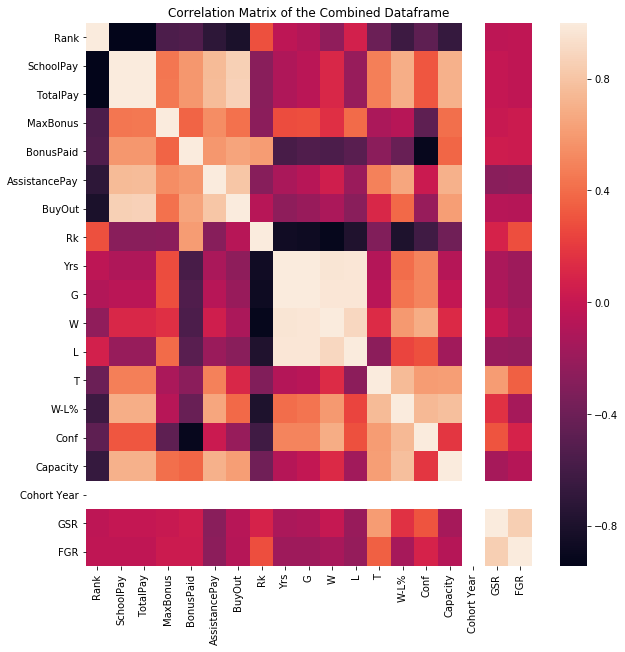

<Figure size 432x288 with 0 Axes>

In [0]:
corr = coach_plus3.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr)
plt.title('Correlation Matrix of the Combined Dataframe')

plt.figure()

###  Feature Engineering

In [0]:
print(len(coach_plus3['Rank']))

80


In [0]:
#top25
coach_plus3['Top25'] = coach_plus3['Rank']
#cleandf.head()


coach_plus3['Top25'].values[coach_plus3['Top25'].values < 25] = 1

coach_plus3['Top25'].values[coach_plus3['Top25'].values >= 25] = 0


coach_plus3.head()

,School_x,Rank,Conference_x,Coach,SchoolPay,TotalPay,MaxBonus,BonusPaid,AssistancePay,BuyOut,...,school,Cohort Year,School_y,Conference_y,Sport,State_y,GSR,FGR,SchoolG,Top25
0,Alabama,1,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,6123723,33600000.0,...,Alabama,2011,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,62,47.0,Alabama,1
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,7504000.0,1325000.0,150000.0,5875000,17111110.0,...,Michigan,2011,University of Michigan,Big Ten Conference,Football,MI,87,69.0,Michigan,1
2,Auburn,5,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,6555600,32143750.0,...,Auburn,2011,Auburn University,Southeastern Conference,Football,AL,72,60.0,Auburn,1
3,Georgia,6,SEC,Kirby Smart,6603600.0,6603600.0,1150000.0,1350000.0,6420000,27917500.0,...,Georgia,2011,Georgia Southern University,Sun Belt Conference,Football,GA,62,50.0,Georgia,1
4,Clemson,7,ACC,Dabo Swinney,6205000.0,6543350.0,1125000.0,500000.0,6825000,35000000.0,...,Clemson,2011,Clemson University,Atlantic Coast Conference,Football,SC,87,70.0,Clemson,1


<Figure size 432x288 with 0 Axes>

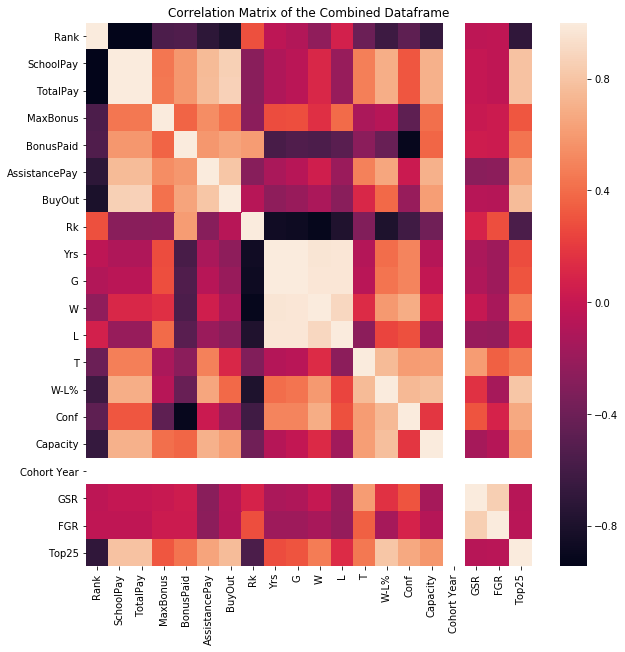

<Figure size 432x288 with 0 Axes>

In [0]:
corr = coach_plus3.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr)
plt.title('Correlation Matrix of the Combined Dataframe')

plt.figure()

##  Data Quality Check

In [0]:
# descriptive statistics
coach_plus3.describe(include=['O'])

,School_x,Conference_x,Coach,Stadium,City,State_x,HomeTeams,school,School_y,Conference_y,Sport,State_y,SchoolG
count,80,80,80,80,80,80,80,80,80,80,80,80,80
unique,80,11,80,79,79,38,80,80,80,19,1,39,80
top,Indiana,Big Ten,Dino Babers,Memorial Stadium,Columbia,Texas,Rutgers Scarlet Knights,Indiana,University of Pittsburgh,Big Ten Conference,Football,TX,Indiana
freq,1,12,1,2,2,6,1,1,1,9,80,5,1


In [0]:
coach_plus3.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,80.0,5.713750e+01,3.376791e+01,1.000,27.750,5.800000e+01,8.225000e+01,1.210000e+02
SchoolPay,80.0,2.624311e+06,1.868127e+06,411000.000,986820.250,2.164819e+06,3.790938e+06,8.307000e+06
TotalPay,80.0,2.633876e+06,1.874701e+06,412500.000,986820.250,2.164819e+06,3.790938e+06,8.307000e+06
MaxBonus,67.0,9.464387e+05,6.601088e+05,70833.000,432500.000,9.000000e+05,1.237500e+06,3.100000e+06
BonusPaid,56.0,1.611919e+05,2.461410e+05,0.000,23750.000,6.757100e+04,1.800000e+05,1.350000e+06
AssistancePay,80.0,2.636028e+06,1.925645e+06,0.000,1055259.500,2.385009e+06,3.987375e+06,6.825000e+06
BuyOut,68.0,9.056662e+06,9.179702e+06,0.000,1518607.500,6.316887e+06,1.299181e+07,3.500000e+07
Rk,6.0,1.960000e+02,1.359779e+02,50.000,93.500,1.645000e+02,3.015000e+02,3.800000e+02
Yrs,6.0,4.666667e+00,3.983298e+00,1.000,2.000,3.000000e+00,7.000000e+00,1.100000e+01
G,6.0,7.216667e+01,6.603156e+01,13.000,23.000,4.800000e+01,1.120000e+02,1.760000e+02


In [0]:
#check NA
coach_plus3.isnull().any()

School_x         False
Rank             False
Conference_x     False
Coach            False
SchoolPay        False
TotalPay         False
MaxBonus          True
BonusPaid         True
AssistancePay    False
BuyOut            True
Rk                True
Yrs               True
G                 True
W                 True
L                 True
T                 True
W-L%              True
Conf              True
Stadium          False
Capacity         False
City             False
State_x          False
HomeTeams        False
school           False
Cohort Year      False
School_y         False
Conference_y     False
Sport            False
State_y          False
GSR              False
FGR              False
SchoolG          False
Top25            False
dtype: bool

In [0]:
coach_plus3.isnull().sum()

School_x          0
Rank              0
Conference_x      0
Coach             0
SchoolPay         0
TotalPay          0
MaxBonus         13
BonusPaid        24
AssistancePay     0
BuyOut           12
Rk               74
Yrs              74
G                74
W                74
L                74
T                74
W-L%             74
Conf             75
Stadium           0
Capacity          0
City              0
State_x           0
HomeTeams         0
school            0
Cohort Year       0
School_y          0
Conference_y      0
Sport             0
State_y           0
GSR               0
FGR               0
SchoolG           0
Top25             0
dtype: int64

In [0]:
# fillna with o

coach_plus3.fillna(0,inplace=True)
coach_plus3.isnull().sum()

School_x         0
Rank             0
Conference_x     0
Coach            0
SchoolPay        0
TotalPay         0
MaxBonus         0
BonusPaid        0
AssistancePay    0
BuyOut           0
Rk               0
Yrs              0
G                0
W                0
L                0
T                0
W-L%             0
Conf             0
Stadium          0
Capacity         0
City             0
State_x          0
HomeTeams        0
school           0
Cohort Year      0
School_y         0
Conference_y     0
Sport            0
State_y          0
GSR              0
FGR              0
SchoolG          0
Top25            0
dtype: int64

The win loss ration will be drop since we have a new column created call top25

All the columns with missing values might be drop. 





In [0]:
coach_plus3.columns

Index(['School_x', 'Rank', 'Conference_x', 'Coach', 'SchoolPay', 'TotalPay',
       'MaxBonus', 'BonusPaid', 'AssistancePay', 'BuyOut', 'Rk', 'Yrs', 'G',
       'W', 'L', 'T', 'W-L%', 'Conf', 'Stadium', 'Capacity', 'City', 'State_x',
       'HomeTeams', 'school', 'Cohort Year', 'School_y', 'Conference_y',
       'Sport', 'State_y', 'GSR', 'FGR', 'SchoolG', 'Top25'],
      dtype='object')

In [0]:
#select columns of interest

colofint = ['School_x', 'Rank', 'Conference_x', 'Coach', 'TotalPay', 'Capacity','GSR', 'Top25','W-L%','Conf','Yrs']

new_coach_plus3 = coach_plus3[colofint]
new_coach_plus3.head()

,School_x,Rank,Conference_x,Coach,TotalPay,Capacity,GSR,Top25,W-L%,Conf,Yrs
0,Alabama,1,SEC,Nick Saban,8307000.0,101821,62,1,0.469,0.0,2.0
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,107601,87,1,0.695,1.0,4.0
2,Auburn,5,SEC,Gus Malzahn,6705656.0,87451,72,1,0.000,0.0,0.0
3,Georgia,6,SEC,Kirby Smart,6603600.0,92746,62,1,0.000,0.0,0.0
4,Clemson,7,ACC,Dabo Swinney,6543350.0,81500,87,1,0.000,0.0,0.0


In [0]:
new_coach_plus3.isnull().sum()

School_x        0
Rank            0
Conference_x    0
Coach           0
TotalPay        0
Capacity        0
GSR             0
Top25           0
W-L%            0
Conf            0
Yrs             0
dtype: int64

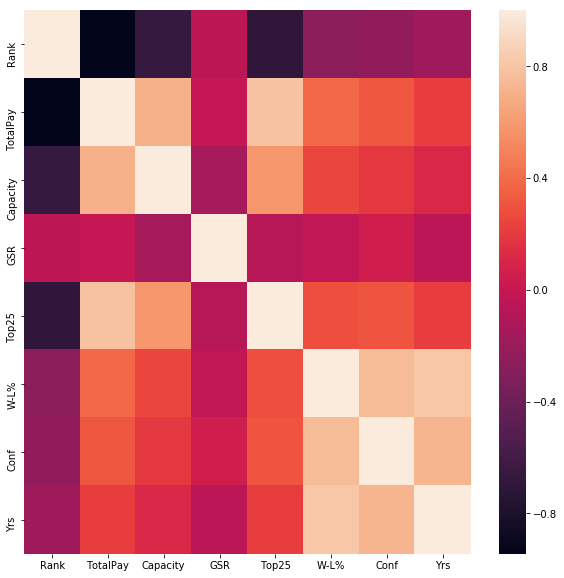

,Rank,TotalPay,Capacity,GSR,Top25,W-L%,Conf,Yrs
Rank,1.000000,-0.944220,-0.667679,-0.038374,-0.695103,-0.263936,-0.234481,-0.178928
TotalPay,-0.944220,1.000000,0.705349,-0.004391,0.791424,0.381567,0.310993,0.211491
Capacity,-0.667679,0.705349,1.000000,-0.145340,0.579501,0.251016,0.189996,0.117853
GSR,-0.038374,-0.004391,-0.145340,1.000000,-0.068954,-0.018004,0.055269,-0.044937
Top25,-0.695103,0.791424,0.579501,-0.068954,1.000000,0.283785,0.308257,0.213442
W-L%,-0.263936,0.381567,0.251016,-0.018004,0.283785,1.000000,0.752465,0.816044
Conf,-0.234481,0.310993,0.189996,0.055269,0.308257,0.752465,1.000000,0.723747
Yrs,-0.178928,0.211491,0.117853,-0.044937,0.213442,0.816044,0.723747,1.000000


In [0]:
corr = new_coach_plus3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr)
plt.show()
corr

In [0]:
new_coach_plus3.columns

Index(['School_x', 'Rank', 'Conference_x', 'Coach', 'TotalPay', 'Capacity',
       'GSR', 'Top25', 'W-L%', 'Conf', 'Yrs'],
      dtype='object')

## EDA

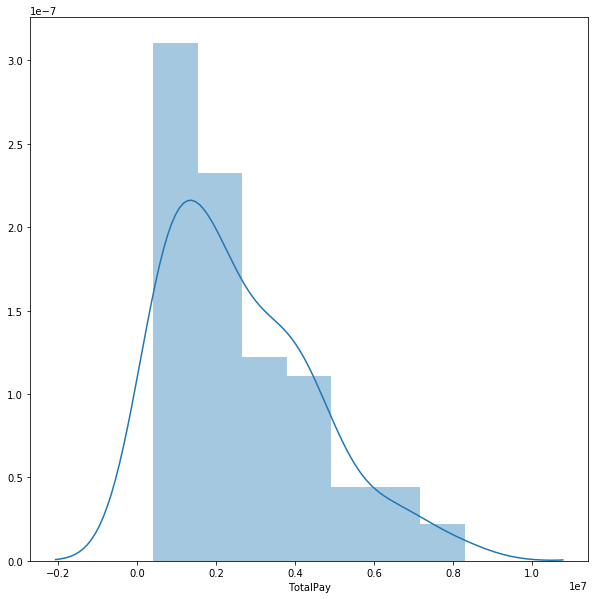

In [0]:
plt.figure(figsize=(10,10))
sns.distplot(new_coach_plus3['TotalPay'])
plt.show()

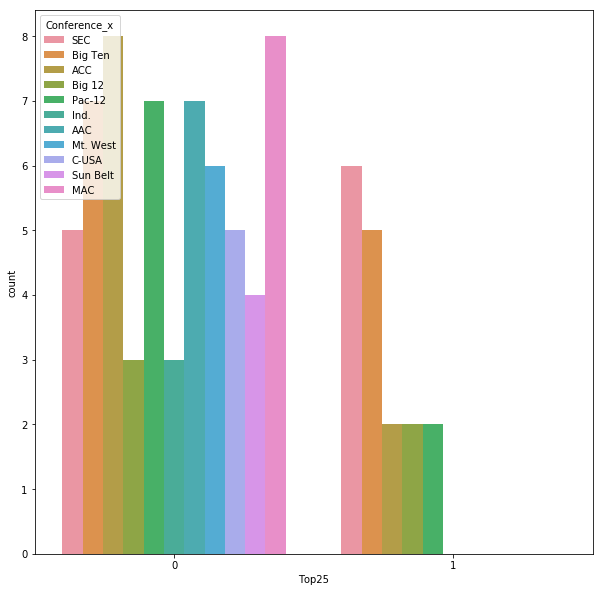

In [0]:
plt.figure(figsize=(10,10))
sns.countplot('Top25', data=new_coach_plus3, hue='Conference_x' )
plt.show()

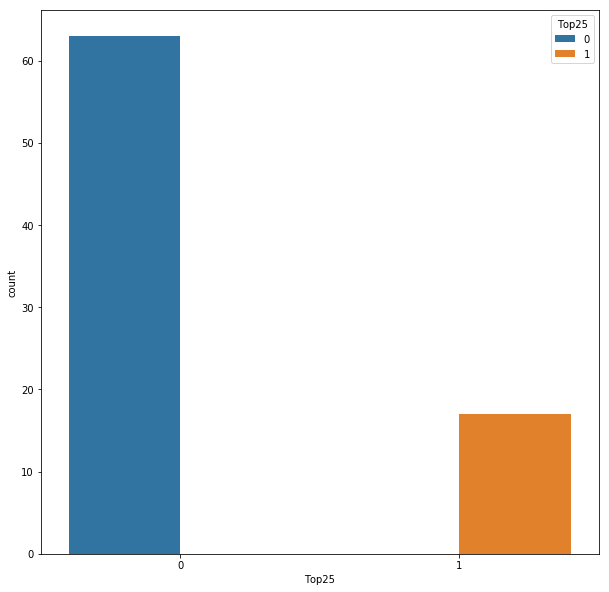

In [0]:
plt.figure(figsize=(10,10))
sns.countplot('Top25', data=new_coach_plus3, hue='Top25' )
plt.show()

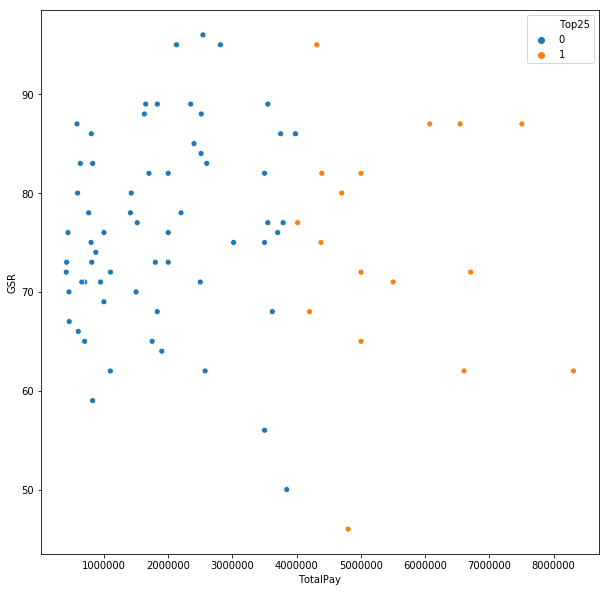

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot('TotalPay', 'GSR', data=new_coach_plus3, hue='Top25')
plt.show()

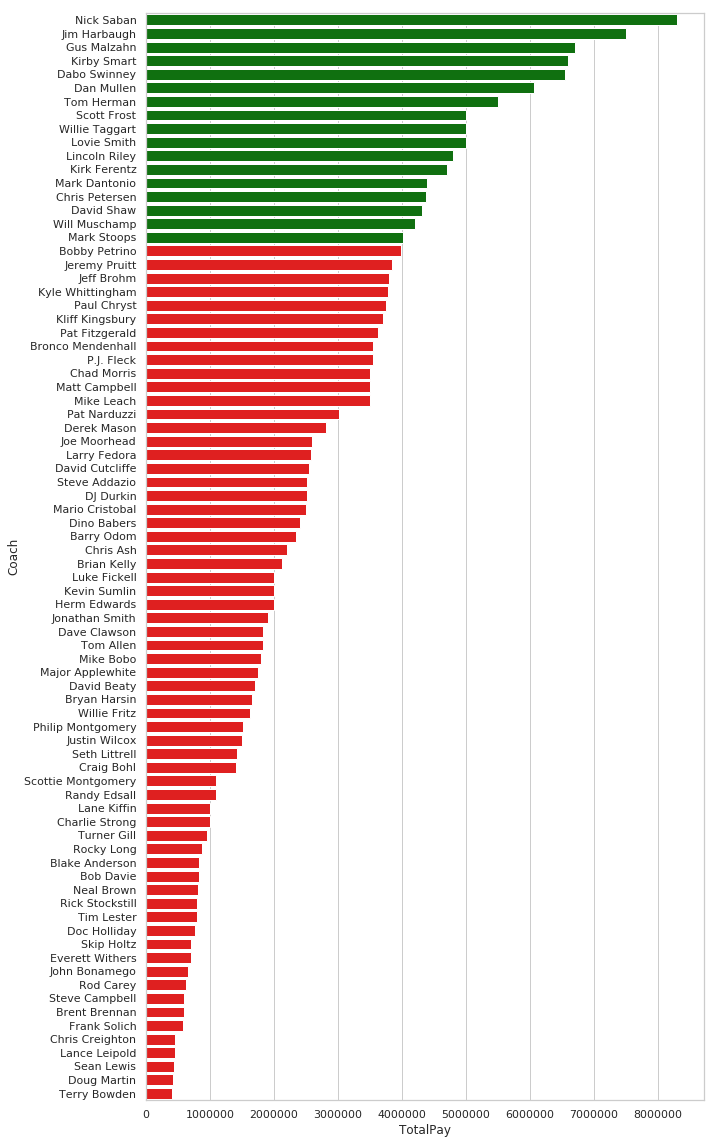

In [0]:
# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 20))


clrs = ['green' if (x == 1 ) else 'red' for x in new_coach_plus3['Top25'].values ]

# Plot the Feature Importance
sns.barplot(x="TotalPay", y='Coach', data=new_coach_plus3, label="Total",  palette=clrs)

Text(0.5, 1.0, 'payment  Distribution - Top25 V.S. Not in Top25')

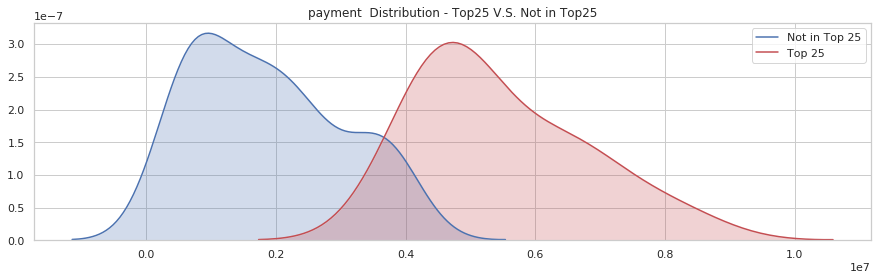

In [0]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_coach_plus3.loc[(new_coach_plus3['Top25'] == 0),'TotalPay'] , color='b',shade=True, label='Not in Top 25')
ax=sns.kdeplot(new_coach_plus3.loc[(new_coach_plus3['Top25'] == 1),'TotalPay'] , color='r',shade=True, label='Top 25')
plt.title('payment  Distribution - Top25 V.S. Not in Top25')

Text(0.5, 1.0, 'Stadium Capacity - Top25 V.S. Not in Top25')

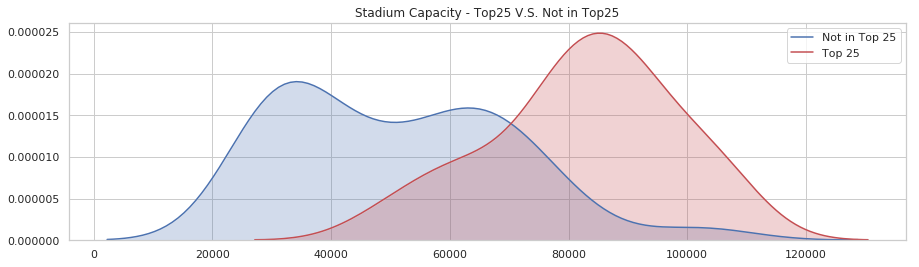

In [0]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_coach_plus3.loc[(new_coach_plus3['Top25'] == 0),'Capacity'] , color='b',shade=True, label='Not in Top 25')
ax=sns.kdeplot(new_coach_plus3.loc[(new_coach_plus3['Top25'] == 1),'Capacity'] , color='r',shade=True, label='Top 25')
plt.title('Stadium Capacity - Top25 V.S. Not in Top25')

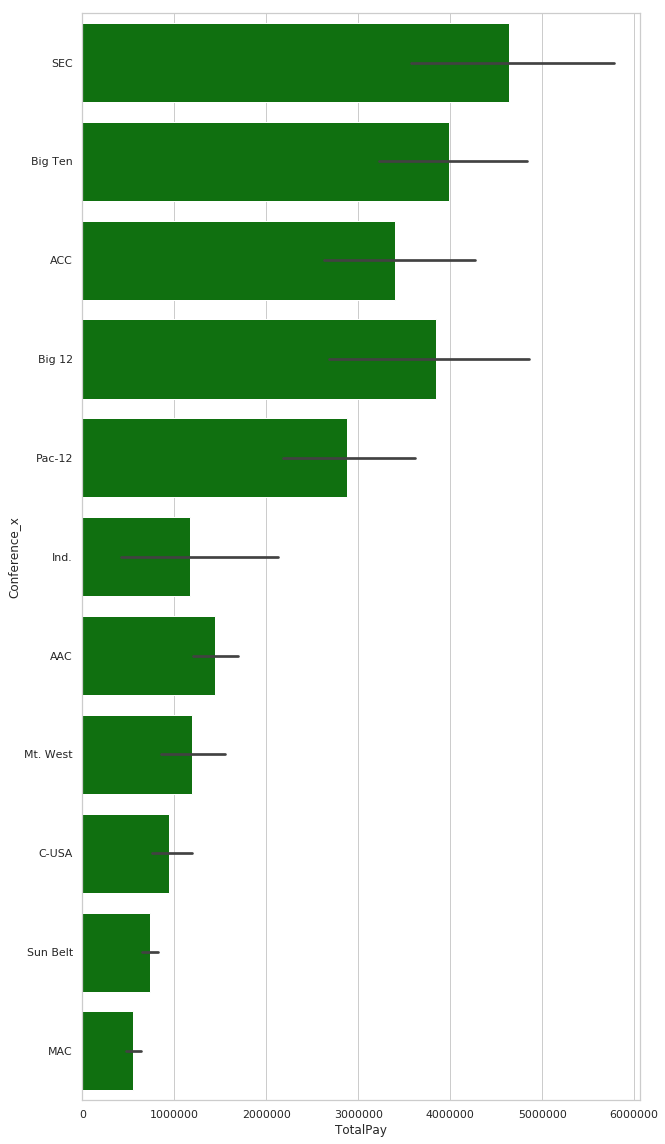

In [0]:
# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 20))


clrs = ['green' if (x == 1 ) else 'red' for x in new_coach_plus3['Top25'].values ]

# Plot the Feature Importance
sns.barplot(x="TotalPay", y='Conference_x', data=new_coach_plus3, label="Total",  palette=clrs)

Text(0.5, 1.0, 'Graduation Success Rate - Top25 V.S. Not in Top25')

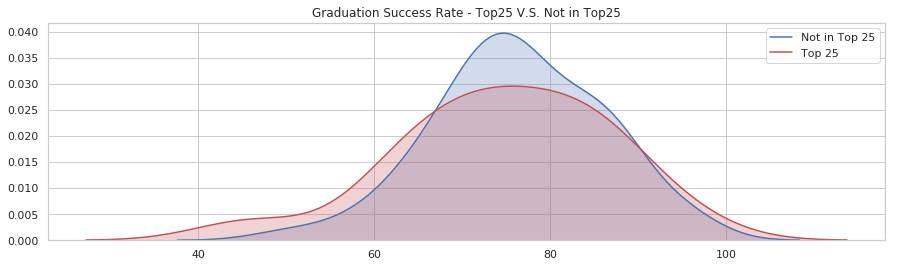

In [0]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_coach_plus3.loc[(new_coach_plus3['Top25'] == 0),'GSR'] , color='b',shade=True, label='Not in Top 25')
ax=sns.kdeplot(new_coach_plus3.loc[(new_coach_plus3['Top25'] == 1),'GSR'] , color='r',shade=True, label='Top 25')
plt.title('Graduation Success Rate - Top25 V.S. Not in Top25')

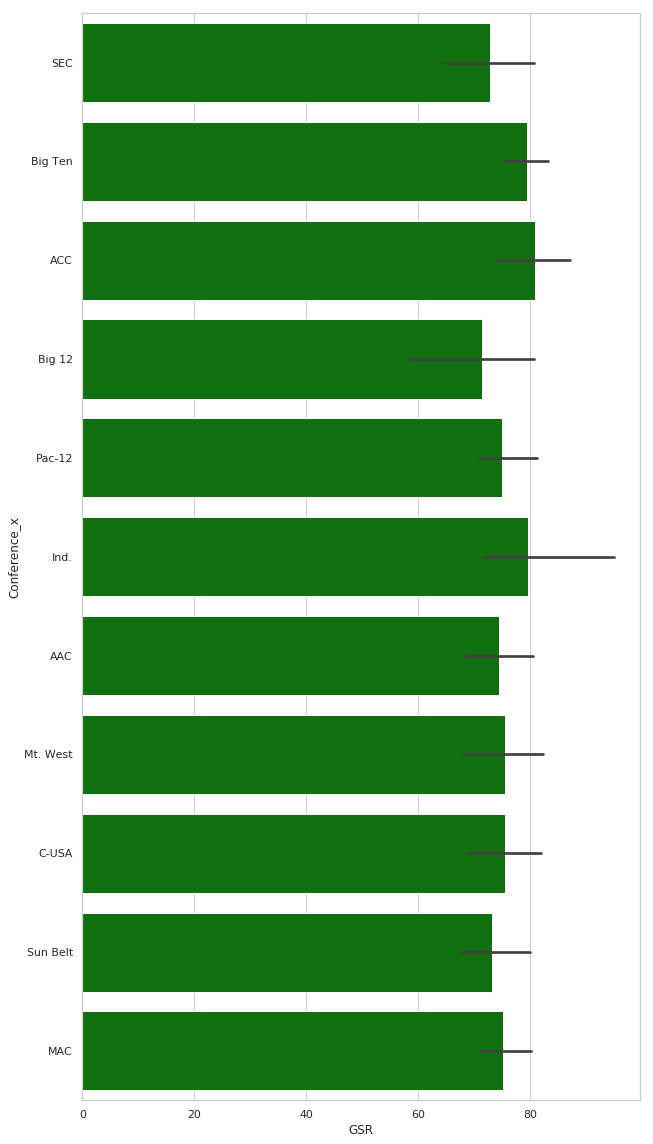

In [0]:
# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 20))


clrs = ['green' if (x == 1 ) else 'red' for x in new_coach_plus3['Top25'].values ]

# Plot the Feature Importance
sns.barplot(x="GSR", y='Conference_x', data=new_coach_plus3, label="Total",  palette=clrs)

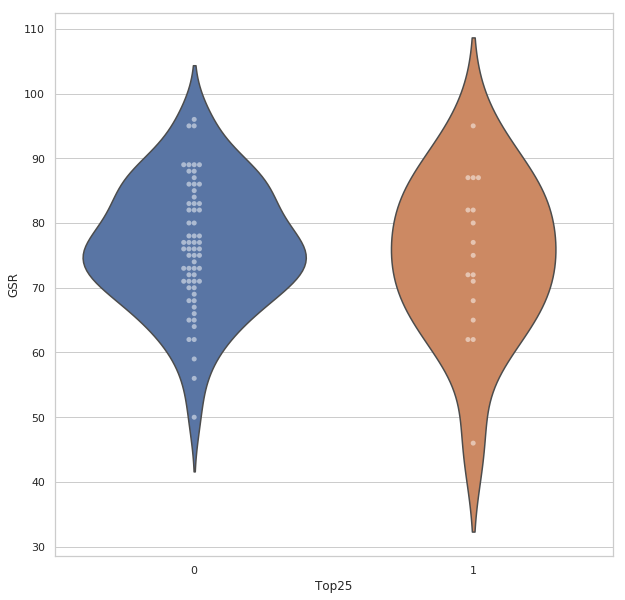

In [0]:
plt.figure(figsize =(10,10))
sns.violinplot(x="Top25", y="GSR", data=new_coach_plus3, inner=None)
sns.swarmplot(x="Top25", y="GSR", data=new_coach_plus3, color="w", alpha=.5)
plt.show()

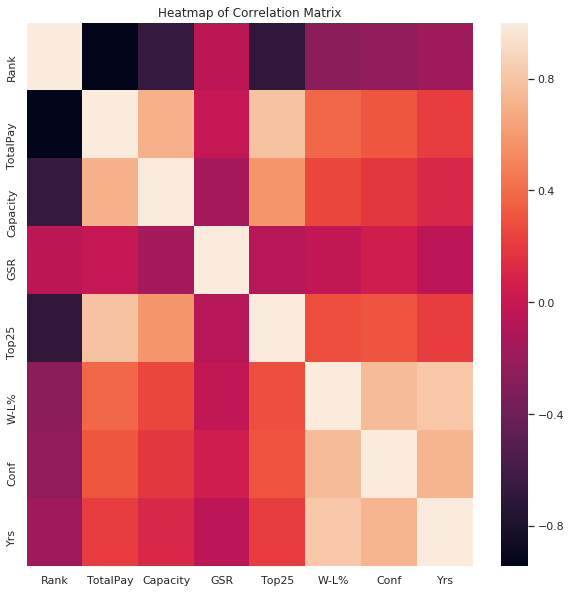

,Rank,TotalPay,Capacity,GSR,Top25,W-L%,Conf,Yrs
Rank,1.000000,-0.944220,-0.667679,-0.038374,-0.695103,-0.263936,-0.234481,-0.178928
TotalPay,-0.944220,1.000000,0.705349,-0.004391,0.791424,0.381567,0.310993,0.211491
Capacity,-0.667679,0.705349,1.000000,-0.145340,0.579501,0.251016,0.189996,0.117853
GSR,-0.038374,-0.004391,-0.145340,1.000000,-0.068954,-0.018004,0.055269,-0.044937
Top25,-0.695103,0.791424,0.579501,-0.068954,1.000000,0.283785,0.308257,0.213442
W-L%,-0.263936,0.381567,0.251016,-0.018004,0.283785,1.000000,0.752465,0.816044
Conf,-0.234481,0.310993,0.189996,0.055269,0.308257,0.752465,1.000000,0.723747
Yrs,-0.178928,0.211491,0.117853,-0.044937,0.213442,0.816044,0.723747,1.000000


In [0]:
## corelation matrix
corr = new_coach_plus3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels= corr.columns.values)
plt.title("Heatmap of Correlation Matrix")
plt.show()
corr

In [0]:
# rename columns

coldict = {'School_x': 'School', 'Rank':'Rank', 'Conference_x':'Conference', 'Coach':'Coach', 'TotalPay':'TotalPay', 'Capacity':'Capacity',
       'GSR': 'GSR', 'Top25':'Top25', 'W-L%':'WL', 'Conf':'Conf', 'Yrs':'Yrs', 'runiform':'runiform'}


new_coach_plus3.rename(index=str, columns=coldict, inplace=True)
new_coach_plus3.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,School,Rank,Conference,Coach,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs
0,Alabama,1,SEC,Nick Saban,8307000.0,101821,62,1,0.469,0.0,2.0
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,107601,87,1,0.695,1.0,4.0
2,Auburn,5,SEC,Gus Malzahn,6705656.0,87451,72,1,0.000,0.0,0.0
3,Georgia,6,SEC,Kirby Smart,6603600.0,92746,62,1,0.000,0.0,0.0
4,Clemson,7,ACC,Dabo Swinney,6543350.0,81500,87,1,0.000,0.0,0.0


In [0]:
import pickle
pickle_out = open('../data/coach_plus3.pickle', 'wb')

pickle.dump(new_coach_plus3, pickle_out)

pickle_out.close()

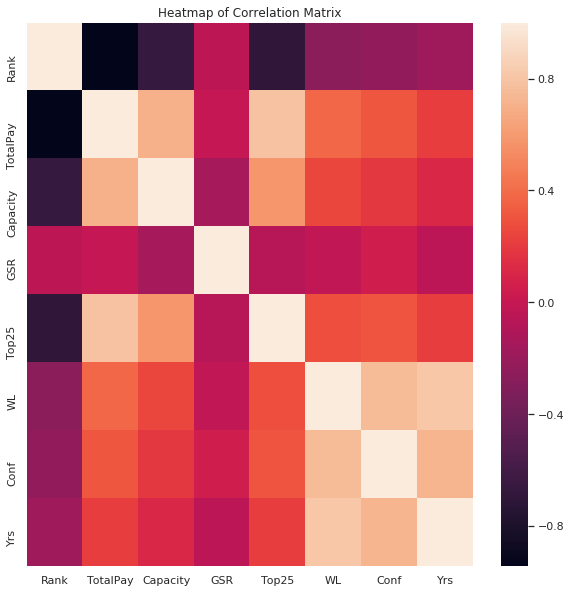

,Rank,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs
Rank,1.000000,-0.944220,-0.667679,-0.038374,-0.695103,-0.263936,-0.234481,-0.178928
TotalPay,-0.944220,1.000000,0.705349,-0.004391,0.791424,0.381567,0.310993,0.211491
Capacity,-0.667679,0.705349,1.000000,-0.145340,0.579501,0.251016,0.189996,0.117853
GSR,-0.038374,-0.004391,-0.145340,1.000000,-0.068954,-0.018004,0.055269,-0.044937
Top25,-0.695103,0.791424,0.579501,-0.068954,1.000000,0.283785,0.308257,0.213442
WL,-0.263936,0.381567,0.251016,-0.018004,0.283785,1.000000,0.752465,0.816044
Conf,-0.234481,0.310993,0.189996,0.055269,0.308257,0.752465,1.000000,0.723747
Yrs,-0.178928,0.211491,0.117853,-0.044937,0.213442,0.816044,0.723747,1.000000


In [0]:
## corelation matrix
corr = new_coach_plus3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels= corr.columns.values)
plt.title("Heatmap of Correlation Matrix")
plt.show()
corr

##  Modeling

In [0]:
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import patsy  # translate model specification into design matrices
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import uniform  # for training-and-test split


class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    
    
def load_file(file):
    '''loads pickle file to dataframe'''
    return pickle.load(open(file, 'rb'))


def get_train_test_stats(df, prop= 0.3):
    '''train:70%, test:30%'''
    df['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(df))

    df_train = df[df['runiform'] >= prop]
    df_test = df[df['runiform'] < prop]
    
    return df_train, df_test


#define inputs : piackle file path for the coaches combined datasets
Coaches = '../data/coach_plus3.pickle'

    
#load data
print("Loading data")
coaches_df = load_file(Coaches)


# get train test

coach_train, coach_test = get_train_test_stats(coaches_df)


print(coach_train.columns)



Loading data
Index(['School', 'Rank', 'Conference', 'Coach', 'TotalPay', 'Capacity', 'GSR',
       'Top25', 'WL', 'Conf', 'Yrs', 'runiform'],
      dtype='object')


In [0]:
# regression 1
ols = smf.ols('TotalPay ~ Rank + Conference + Top25 + GSR + Capacity + WL + Conf + Yrs', data=coach_train).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     66.98
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           8.32e-26
Time:                        01:34:26   Log-Likelihood:                -875.79
No. Observations:                  62   AIC:                             1788.
Df Residuals:                      44   BIC:                             1826.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.06

In [0]:
#regression 2
ols = smf.ols('TotalPay ~ Rank + Conference + Top25 ', data=coach_train).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     104.7
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           1.29e-30
Time:                        01:37:04   Log-Likelihood:                -876.08
No. Observations:                  62   AIC:                             1778.
Df Residuals:                      49   BIC:                             1806.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                4.7

In [0]:
#regression 3

ols_2 = smf.ols('TotalPay ~ Rank  + Top25', data=coach_train).fit()

print(ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     555.0
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           5.48e-39
Time:                        01:50:06   Log-Likelihood:                -885.25
No. Observations:                  62   AIC:                             1776.
Df Residuals:                      59   BIC:                             1783.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.75e+06   1.44e+05     32.937      0.0

In [0]:
prediction = ols.predict(coach_test)

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(prediction, coach_test['TotalPay'])

627769684702.1055

In [0]:
print('{} : {} '.format(prediction, coach_test['TotalPay']))

0     5.945154e+06
1     5.483557e+06
5     5.625135e+06
15    5.030813e+06
25    3.274209e+06
38    2.638597e+06
39    2.222717e+06
45    2.128413e+06
47    2.022144e+06
50    1.839275e+06
51    1.524094e+06
54    1.525708e+06
57    1.112641e+06
59    1.021206e+06
62    1.130026e+06
66    1.292166e+06
68    5.199332e+05
76    2.863910e+05
dtype: float64 : 0     8307000.0
1     7504000.0
5     6070000.0
15    4200000.0
25    3550000.0
38    2350000.0
39    2200000.0
45    1831580.0
47    1800000.0
50    1650010.0
51    1629000.0
54    1425000.0
57    1100000.0
59    1000000.0
62     825000.0
66     800000.0
68     700000.0
76     455500.0
Name: TotalPay, dtype: float64 


In [0]:
prediction = ols_2.predict(coach_test)
mean_squared_error(prediction, coach_test['TotalPay'])

695854937306.519

In [0]:
print('{} : {} '.format(prediction, coach_test['TotalPay']))

0     5.662853e+06
1     5.580489e+06
5     5.374581e+06
15    4.839221e+06
25    3.350045e+06
38    2.444050e+06
39    2.402868e+06
45    2.114597e+06
47    2.032234e+06
50    1.867507e+06
51    1.826326e+06
54    1.661599e+06
57    1.455692e+06
59    1.373328e+06
62    1.085057e+06
66    8.791493e+05
68    7.556045e+05
76   -2.684573e+04
dtype: float64 : 0     8307000.0
1     7504000.0
5     6070000.0
15    4200000.0
25    3550000.0
38    2350000.0
39    2200000.0
45    1831580.0
47    1800000.0
50    1650010.0
51    1629000.0
54    1425000.0
57    1100000.0
59    1000000.0
62     825000.0
66     800000.0
68     700000.0
76     455500.0
Name: TotalPay, dtype: float64 


## Log Tranformation of Salary

### Regression

In [0]:
#np.random.seed(1234)
#coaches_df['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(coaches_df))
#coach_train = susitemdf[susitemdf['runiform'] >= 0.33]
#coach_test = susitemdf[susitemdf['runiform'] < 0.33]
# check training data frame
#print('\SusItems_train data frame (rows, columns): ',susitemdf_train.shape)
#print(susitemdf_train.head())
# check test data frame
#print('\SusItems_test data frame (rows, columns): ',susitemdf_test.shape)
#print(susitemdf_test.head())

# specify a simple model with bobblehead entered last
#my_model = str('TotalPay ~ Rank + Top25 ')

# fit the model to the training set
#train_model_fit = smf.ols(my_model, data = coach_train).fit()
# summary of model fit to the training set
#print(train_model_fit.summary())

In [0]:
# log tranformation of the total pay
coaches_df.head()

,School,Rank,Conference,Coach,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs,runiform
0,Alabama,1,SEC,Nick Saban,8307000.0,101821,62,1,0.469,0.0,2.0,0.206412
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,107601,87,1,0.695,1.0,4.0,0.040828
2,Auburn,5,SEC,Gus Malzahn,6705656.0,87451,72,1,0.000,0.0,0.0,0.592055
3,Georgia,6,SEC,Kirby Smart,6603600.0,92746,62,1,0.000,0.0,0.0,0.621533
4,Clemson,7,ACC,Dabo Swinney,6543350.0,81500,87,1,0.000,0.0,0.0,0.589868


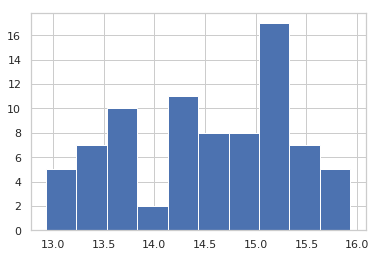

In [0]:
coaches_df['TotalPay'].apply(np.log).hist()

In [0]:
coaches_df['logTotalPay'] = coaches_df['TotalPay'].apply(np.log)

In [0]:
coaches_df.head()

,School,Rank,Conference,Coach,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs,runiform,logTotalPay
0,Alabama,1,SEC,Nick Saban,8307000.0,101821,62,1,0.469,0.0,2.0,0.206412,15.932609
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,107601,87,1,0.695,1.0,4.0,0.040828,15.830947
2,Auburn,5,SEC,Gus Malzahn,6705656.0,87451,72,1,0.000,0.0,0.0,0.592055,15.718462
3,Georgia,6,SEC,Kirby Smart,6603600.0,92746,62,1,0.000,0.0,0.0,0.621533,15.703126
4,Clemson,7,ACC,Dabo Swinney,6543350.0,81500,87,1,0.000,0.0,0.0,0.589868,15.693960


In [0]:
coach_train, coach_test = get_train_test_stats(coaches_df)

In [0]:
#regression 1

ols = ols = smf.ols('logTotalPay ~ Rank + Conference + Top25 + GSR + Capacity + WL + Conf + Yrs', data=coach_train).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            logTotalPay   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     410.8
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           3.43e-45
Time:                        02:01:09   Log-Likelihood:                 86.468
No. Observations:                  65   AIC:                            -136.9
Df Residuals:                      47   BIC:                            -97.80
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 15

In [0]:
prediction = ols.predict(coach_test)
prediction

1     16.818744
2     15.656812
11    15.344073
14    15.372124
28    15.011326
32    14.675492
33    14.741305
43    13.746944
47    14.325981
52    14.137513
61    13.852673
69    13.410688
71    13.360513
73    13.404246
75    13.044016
dtype: float64

In [0]:
coach_test['logTotalPay']

1     15.830947
2     15.718462
11    15.363073
14    15.276806
28    15.068274
32    14.761360
33    14.748040
43    14.508658
47    14.403297
52    14.233021
61    13.680350
69    13.458836
71    13.358952
73    13.288596
75    13.038982
Name: logTotalPay, dtype: float64

In [0]:
mean_squared_error(prediction, coach_test['logTotalPay'])

0.10935833335263405

In [0]:
#regression 2
ols = smf.ols('logTotalPay ~ Rank + Conference + Top25 + GSR', data=coach_train).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            logTotalPay   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     538.6
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           8.99e-50
Time:                        02:07:06   Log-Likelihood:                 83.909
No. Observations:                  65   AIC:                            -139.8
Df Residuals:                      51   BIC:                            -109.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 15

In [0]:
prediction = ols.predict(coach_test)
print(mean_squared_error(prediction, coach_test['logTotalPay']))
prediction

0.006494960038771859


1     15.690475
2     15.675098
11    15.350939
14    15.383405
28    15.022671
32    14.680384
33    14.747380
43    14.467059
47    14.317083
52    14.145274
61    13.838196
69    13.411216
71    13.367573
73    13.395463
75    13.050094
dtype: float64

In [0]:
prediction = ols.predict(coach_test)
print(mean_squared_error(prediction, coach_test['logTotalPay']))
prediction

0.006494960038771859


1     15.690475
2     15.675098
11    15.350939
14    15.383405
28    15.022671
32    14.680384
33    14.747380
43    14.467059
47    14.317083
52    14.145274
61    13.838196
69    13.411216
71    13.367573
73    13.395463
75    13.050094
dtype: float64

In [0]:
print(coaches_df[coaches_df['School'] == 'Syracuse'])

      School  Rank Conference        Coach   TotalPay  Capacity  GSR  Top25  \
37  Syracuse    55        ACC  Dino Babers  2401206.0     49262   85      0   

     WL  Conf  Yrs  runiform  logTotalPay  
37  0.0   0.0  0.0  0.717467    14.691482  


In [0]:
coaches_df.columns

Index(['School', 'Rank', 'Conference', 'Coach', 'TotalPay', 'Capacity', 'GSR',
       'Top25', 'WL', 'Conf', 'Yrs', 'runiform', 'logTotalPay'],
      dtype='object')

In [0]:
round(np.exp(ols.predict(coaches_df[coaches_df['School'] == 'Syracuse'])),1)

37    2250282.5
dtype: float64

In [0]:
prediction = ols.predict(coaches_df)

coaches_df['predictionlog'] = prediction
coaches_df['prediction'] = round(np.exp(prediction),1)


coaches_df.head(20)


,School,Rank,Conference,Coach,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs,runiform,logTotalPay,predictionlog,prediction
0,Alabama,1,SEC,Nick Saban,8307000.0,101821,62,1,0.469,0.0,2.0,0.882059,15.932609,15.740369,6854180.4
1,Michigan,3,Big Ten,Jim Harbaugh,7504000.0,107601,87,1,0.695,1.0,4.0,0.063725,15.830947,15.690475,6520585.9
2,Auburn,5,SEC,Gus Malzahn,6705656.0,87451,72,1,0.000,0.0,0.0,0.186091,15.718462,15.675098,6421085.5
3,Georgia,6,SEC,Kirby Smart,6603600.0,92746,62,1,0.000,0.0,0.0,0.378695,15.703126,15.625719,6111720.1
4,Clemson,7,ACC,Dabo Swinney,6543350.0,81500,87,1,0.000,0.0,0.0,0.344444,15.693960,15.627595,6123200.6
5,Florida,8,SEC,Dan Mullen,6070000.0,88548,87,1,0.000,0.0,0.0,0.345467,15.618869,15.645981,6236818.2
6,Texas,9,Big 12,Tom Herman,5500000.0,102733,71,1,0.000,0.0,0.0,0.730784,15.520259,15.552264,5678879.4
7,Nebraska,10,Big Ten,Scott Frost,5000000.0,89959,82,1,0.000,0.0,0.0,0.558615,15.424948,15.516740,5480679.7
8,Florida State,12,ACC,Willie Taggart,5000000.0,79560,65,1,0.000,0.0,0.0,0.313079,15.424948,15.454758,5151289.2
9,Illinois,13,Big Ten,Lovie Smith,5000000.0,60670,72,1,0.506,1.0,11.0,0.751833,15.424948,15.421501,4982790.1


In [0]:
coaches_df.columns

Index(['School', 'Rank', 'Conference', 'Coach', 'TotalPay', 'Capacity', 'GSR',
       'Top25', 'WL', 'Conf', 'Yrs', 'runiform', 'logTotalPay',
       'predictionlog', 'prediction'],
      dtype='object')

In [0]:
cols = ['School', 'Coach','TotalPay','prediction']

df = coaches_df[cols]

df.head(20)

,School,Coach,TotalPay,prediction
0,Alabama,Nick Saban,8307000.0,6854180.4
1,Michigan,Jim Harbaugh,7504000.0,6520585.9
2,Auburn,Gus Malzahn,6705656.0,6421085.5
3,Georgia,Kirby Smart,6603600.0,6111720.1
4,Clemson,Dabo Swinney,6543350.0,6123200.6
5,Florida,Dan Mullen,6070000.0,6236818.2
6,Texas,Tom Herman,5500000.0,5678879.4
7,Nebraska,Scott Frost,5000000.0,5480679.7
8,Florida State,Willie Taggart,5000000.0,5151289.2
9,Illinois,Lovie Smith,5000000.0,4982790.1


In [0]:
df.tail(20)

,School,Coach,TotalPay,prediction
60,Liberty,Turner Gill,947281.0,1021139.9
61,San Diego State,Rocky Long,873576.0,1022944.7
62,Arkansas State,Blake Anderson,825000.0,866533.1
63,New Mexico,Bob Davie,823740.0,917797.8
64,Troy,Neal Brown,810000.0,806086.7
65,Middle Tennessee,Rick Stockstill,803004.0,834310.5
66,Western Michigan,Tim Lester,800000.0,768952.6
67,Marshall,Doc Holliday,762570.0,780228.2
68,Louisiana Tech,Skip Holtz,700000.0,720065.9
69,Texas State,Everett Withers,700000.0,667447.5


In [0]:
df[25:50]

,School,Coach,TotalPay,prediction
25,Minnesota,P.J. Fleck,3550000.0,3576291.0
26,Arkansas,Chad Morris,3500000.0,3435874.2
27,Iowa State,Matt Campbell,3500000.0,3416819.6
28,Washington State,Mike Leach,3500000.0,3343974.5
29,Pittsburgh,Pat Narduzzi,3017718.0,2952635.6
30,Vanderbilt,Derek Mason,2812523.0,2960004.5
31,Mississippi State,Joe Moorhead,2600000.0,2676906.6
32,North Carolina,Larry Fedora,2575000.0,2374706.7
33,Duke,David Cutcliffe,2540928.0,2539252.8
34,Boston College,Steve Addazio,2514859.0,2429731.4


In [0]:
import pickle
pickle_out = open('../data/coach_model.pickle', 'wb')

pickle.dump(ols, pickle_out)

pickle_out.close()

In [0]:
# school Omitted

school = coaches_html['School'].values
useschool = coaches_df['School'].values

dropschool = []

for i in school:
  if i not in useschool:
    dropschool.append(i)
    
    
print(dropschool)

['Ohio State', 'Texas A&M', 'Oklahoma State', 'Texas Christian', 'Penn State', 'Miami (Fla.)', 'Virginia Tech', 'West Virginia', 'LSU', 'Kansas State', 'UCLA', 'Georgia Tech', 'North Carolina State', 'Mississippi', 'Colorado', 'Southern California', 'Memphis', 'Navy', 'Central Florida', 'Fresno State', 'Toledo', 'Texas-San Antonio', 'Florida International', 'Utah State', 'Alabama at Birmingham', 'Louisiana-Lafayette', 'Western Kentucky', 'Appalachian State', 'Texas-El Paso', 'Old Dominion', 'Georgia Southern', 'Charlotte', 'Nevada-Las Vegas', 'Georgia State', 'Miami (Ohio)', 'Southern Mississippi', 'Massachusetts', 'Nevada', 'Hawaii', 'Bowling Green', 'Ball State', 'Coastal Carolina', 'Louisiana-Monroe', 'Baylor', 'Air Force', 'Brigham Young', 'Rice', 'Temple', 'Southern Methodist', 'Army']


In [0]:
print(len(dropschool))

50


In [0]:
#regression 3
ols_3 = smf.ols('logTotalPay ~ Rank + Top25 + GSR', data=coach_train).fit()

print(ols_3.summary())

                            OLS Regression Results                            
Dep. Variable:            logTotalPay   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2032.
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           4.71e-61
Time:                        02:45:15   Log-Likelihood:                 73.682
No. Observations:                  65   AIC:                            -139.4
Df Residuals:                      61   BIC:                            -130.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.7960      0.086    183.714      0.0

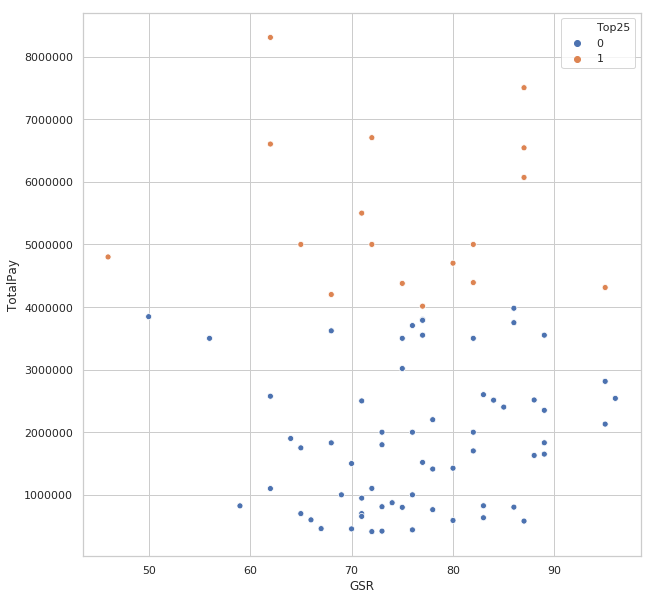

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot('GSR', 'TotalPay',hue='Top25', data=coaches_df)
plt.show()

In [0]:
#Y =  15.6155 + (0.0474 * Conference[T.ACC]) + (0.0602 * Conference[T.Big 12]) + (0.0186 * Conference[T.Big Ten]) +
#(-0.0761 * Conference[T.C-USA]) + (-0.0637 * Conference[T.Ind.]) + (-0.1057 * Conference[T.MAC]) + (0.0219 * Conference[T.Mt. West]) +
#(0.0801 * Conference[T.Pac-12])+ (0.0887 * Conference[T.SEC]) + (-0.1220 * Conference[T.Sun Belt]) + (-0.0229 * Rank) + (-0.1049* Top25) + (0.0026 * GSR  )

In [0]:
#final model
ols = smf.ols('logTotalPay ~ Rank + Conference + Top25 + GSR', data=coach_train).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            logTotalPay   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     538.6
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           8.99e-50
Time:                        03:26:10   Log-Likelihood:                 83.909
No. Observations:                  65   AIC:                            -139.8
Df Residuals:                      51   BIC:                            -109.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 15

In [0]:
syr = coach_train[coach_train['School'] == 'Syracuse']
syr

,School,Rank,Conference,Coach,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs,runiform,logTotalPay
37,Syracuse,55,ACC,Dino Babers,2401206.0,49262,85,0,0.0,0.0,0.0,0.717467,14.691482


In [0]:
round(np.exp(ols.predict(syr)),1)

37    2250282.5
dtype: float64

In [0]:
syr['Conference'] = 'Big Ten'

syr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,School,Rank,Conference,Coach,TotalPay,Capacity,GSR,Top25,WL,Conf,Yrs,runiform,logTotalPay
37,Syracuse,55,Big Ten,Dino Babers,2401206.0,49262,85,0,0.0,0.0,0.0,0.717467,14.691482


In [0]:
round(np.exp(ols.predict(syr)),1)

37    2186308.8
dtype: float64

# hierarchical model

In [0]:
import pymc3 as pm